# CapitalOne Data Challenge - Data Processing

**Firstly, I loaded required packages, then imported the dataset by using pandas package. Before importing, I changed Null values to NaN in '.txt' file since Python does not convert Null values as NaN.**

In [110]:
#load package
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [111]:
def concat(x):
    y=str('T') + str(x)
    return y

In [112]:
file_path= './Desktop/DS-master/cardtransactions.txt' # path of the file

**Data Pre-Processing**

In [113]:
# create import function
def import_data(path):
    dfList = []
    df=pd.DataFrame()
    for iot_chunk in pd.read_json(file_path, lines=True,chunksize=100000) :
        dfList.append(iot_chunk)
    df = pd.concat(dfList,sort=False)
    return df

In [114]:
pd.set_option('display.max_columns', None) # pandas setting
transactions=import_data(file_path) # execute the function
transactions.head(3)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,1.0,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,1.0,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,1.0,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False


In [115]:
transactions.posEntryMode.unique()

array([ 2.,  9.,  5., 80., 90., nan])

In [116]:
transactions.posConditionCode.unique()

array([ 1.,  8., 99., nan])

**I removed several columns including all Null values in the dataset to reduce dimensionality.**

In [123]:
pd.DataFrame(transactions.isnull().sum()).reset_index(drop=False).sort_values(by=0,ascending=False)[:11]

,index,0
26,recurringAuthInd,786363
25,posOnPremises,786363
23,merchantZip,786363
22,merchantState,786363
21,merchantCity,786363
19,echoBuffer,786363
7,acqCountry,4562
9,posEntryMode,4054
8,merchantCountryCode,724
18,transactionType,698


In [28]:
transactions.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'],
                  axis=1,inplace=True)

**I created 'Date' column by splitting original 'TransactionDate' column.The dataset obtains transactions in year 2016.**

In [29]:
transactions['Date']=transactions['transactionDateTime'].apply(lambda x: x.split('T')[0]) # create 'Date' column

In [30]:
transactions.reset_index(drop=False,inplace=True)
transactions['transactionKey']=transactions['index'].apply(lambda x: concat(x))
transactions.drop(['index'],axis=1,inplace=True)

**This table indicates how many transactions each account had for each merchant in year 2016. (use the table in the next steps)**

In [31]:
cust_length=transactions.groupby(['customerId','merchantName']).count()['Date']
cust_length=pd.DataFrame(cust_length).reset_index()
cust_length.columns=['customerId','merchantName','Count']
cust_length.head()

,customerId,merchantName,Count
0,100088067,1st BBQ,1
1,100088067,1st Pub,1
2,100088067,1st Sandwitch Bar #758805,1
3,100088067,34th BBQ #412895,1
4,100088067,AMC #191138,1


-----

# Data Pre-Processing | Case Study 1: Detect Reversal transactions

**Firstly, I created Timestamp feature by modifying 'transactionDateTime' column and replaced null values of transaction type with 'Purchase'. Then, I sorted datasets based on several columns such as customerID, merchantName and Timestamp in ascending order.**

In [33]:
card_data=transactions.copy() # make a copy
card_data['transactionType']=card_data['transactionType'].fillna(value='PURCHASE')
card_data['Date']=card_data['transactionDateTime'].apply(lambda x: x.split('T')[0]) # create 'Date' column
card_data['Time']=card_data['transactionDateTime'].apply(lambda x: x.split('T')[1]) # create 'Date' column
card_data.Date=pd.to_datetime(card_data.Date)
card_data['Timestamp']=pd.to_datetime(card_data.Date.astype(str)+' '+card_data.Time.astype(str))

In [34]:
card_data=card_data[['customerId','merchantName','transactionAmount','transactionType','transactionKey','Timestamp']]
card_data=card_data.sort_values(by=['customerId','merchantName','Timestamp'],ascending=True)

**Assumption 1: Transaction amount of 'address_verification' is 0; there is no effect in modeling part. Hence, I removed the transactions whose type is 'address_verification'.**

In [35]:
# remove the observations including 'ADDRESS_VERIIFICATION'
card_data=card_data.reset_index(drop=True)
card_data=card_data[-(card_data.transactionType=='ADDRESS_VERIFICATION')]
card_data=card_data.reset_index(drop=True)

**Assumption 2: I suppose that purchase and reversal transactions are successive and the same $ amount. Hence, I took indexes of reversal transactions and purchase transactions by using 'transactionType' feature.**

In [36]:
reversal_index=card_data[card_data['transactionType']=='REVERSAL'].index.values.astype(int)

In [37]:
second_reversal=card_data.iloc[reversal_index]
second_reversal.head(2)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
13,100088067,AMC #79863,22.32,REVERSAL,T541964,2016-11-20 08:00:04
124,100328049,Lyft,43.74,REVERSAL,T87920,2016-01-15 20:36:18


In [38]:
previous_index=reversal_index-1

In [39]:
first_reversal=card_data.iloc[previous_index]
first_reversal.head(2)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
12,100088067,AMC #79863,22.32,PURCHASE,T541963,2016-11-20 07:57:05
123,100328049,Lyft,43.74,PURCHASE,T87919,2016-01-15 20:34:35


**I created the dataframe which demonstrates indexes and transaction amounts of purchase and reversal transactions. Then, I realized that purchase transactions and its reversal transactions do not have to be consecutive.**

In [40]:
previndex=pd.DataFrame(previous_index)
previndex.columns=['Purchase_Index'] # rename columns

In [41]:
revindex=pd.DataFrame(reversal_index)
revindex.columns=['Reversal_Index'] # rename columns

In [42]:
firstreverse=pd.DataFrame(first_reversal['transactionAmount'].values)
firstreverse.columns=['Purchase_Amount'] # rename columns

In [43]:
secondreverse=pd.DataFrame(second_reversal['transactionAmount'].values)
secondreverse.columns=['Reversal_Amount'] # rename columns

In [44]:
logic=pd.concat([previndex,firstreverse,revindex,secondreverse],axis=1) # merge all dataframes vertically
logic.head()

,Purchase_Index,Purchase_Amount,Reversal_Index,Reversal_Amount
0,12,22.32,13,22.32
1,123,43.74,124,43.74
2,139,284.97,140,284.97
3,262,93.67,263,93.67
4,277,501.29,278,501.29


In [45]:
logic['NotEqual']=logic[['Purchase_Amount','Reversal_Amount']].apply(lambda x: True if (x[0]!=x[1]) else False,axis=1)

In [46]:
logic=logic[-(logic.Reversal_Amount==0)] # exlude the transactions whose amount is $0.

In [47]:
logic.NotEqual.value_counts() # check whether purchase and reversal transactions are successive or not

False    12665
True      7066
Name: NotEqual, dtype: int64

**I saved the transactions whose purchase and reversal types are consecutive (size:12665)**

In [48]:
capture1=logic.loc[logic['NotEqual'] == False, 'Reversal_Index'].values #take reversal indexes
capture2=logic.loc[logic['NotEqual'] == False, 'Purchase_Index'].values #take purchase indexes
cpt=np.concatenate((capture1, capture2)) # combine two arrays
cpt1=card_data.iloc[cpt] # take dataframe regarding these indexes

In [49]:
cpt1=cpt1.sort_values(by=['customerId','merchantName','Timestamp'],ascending=True)
cpt1.head(3)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
12,100088067,AMC #79863,22.32,PURCHASE,T541963,2016-11-20 07:57:05
13,100088067,AMC #79863,22.32,REVERSAL,T541964,2016-11-20 08:00:04
123,100328049,Lyft,43.74,PURCHASE,T87919,2016-01-15 20:34:35


In [50]:
cpt1.transactionType.value_counts() # check the distribution

REVERSAL    12665
PURCHASE    12665
Name: transactionType, dtype: int64

In [51]:
warnings.filterwarnings("ignore")
cpt1['ID'] = cpt1.customerId.map(str) + "-" + cpt1.merchantName
cpt1.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,ID
12,100088067,AMC #79863,22.32,PURCHASE,T541963,2016-11-20 07:57:05,100088067-AMC #79863
13,100088067,AMC #79863,22.32,REVERSAL,T541964,2016-11-20 08:00:04,100088067-AMC #79863
123,100328049,Lyft,43.74,PURCHASE,T87919,2016-01-15 20:34:35,100328049-Lyft
124,100328049,Lyft,43.74,REVERSAL,T87920,2016-01-15 20:36:18,100328049-Lyft
139,100328049,McDonalds #423357,284.97,PURCHASE,T87935,2016-03-24 22:57:15,100328049-McDonalds #423357


**I will capture purchase transactions associated to 7066 reversal observations in the later step.**

In [52]:
rvs=logic.loc[logic['NotEqual'] == True, 'Reversal_Index'].values 

In [53]:
nexts=card_data.iloc[rvs]

In [54]:
nexts.head(5)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
669,101380713,sears.com,5.03,REVERSAL,T3010,2016-06-22 22:10:22
848,101661970,American Airlines,18.15,REVERSAL,T470094,2016-04-24 14:03:36
1047,101738384,discount.com,174.92,REVERSAL,T736347,2016-03-17 05:37:44
1161,101738384,staples.com,954.71,REVERSAL,T736421,2016-06-11 00:47:21
1329,101876201,discount.com,163.75,REVERSAL,T542091,2016-06-28 10:10:22


In [55]:
nexts.transactionKey.nunique()

7066

In [56]:
card_upd=card_data[-(card_data.transactionType=='REVERSAL')]

In [57]:
warnings.filterwarnings("ignore")
nexts['ID'] = nexts.customerId.map(str) + "-" + nexts.merchantName

**I wrote the "for loop" below which helps exploring purchase transactions associated to reversal ones when they are not consecutive.**

In [58]:
dfz={}
for i in nexts.customerId.unique():
    for j in nexts.merchantName.unique():
        if str(i) + "-"+j in nexts.ID.unique():
            inter=nexts[(nexts.customerId==i) & (nexts.merchantName==j)]
            size=len(inter)
            for k in range(size):
                z=inter.iloc[k]
                amnt=z.transactionAmount
                df=card_upd[(card_upd.customerId==i) & (card_upd.merchantName==j)]
                q=df[(df.transactionAmount==amnt)]
            dfz[i,j,k]=q

**After, I created the dataframe to combine all purchase transactions associated to reversal ones.**

In [59]:
nrow=len(dfz.keys())
df_upd_data=pd.DataFrame()
for i in range(nrow):
    df_inter=dfz[[*dfz.keys()][i]]
    df_upd_data=df_upd_data.append(df_inter)
df_upd_data=df_upd_data.reset_index(drop=True)
df_upd_data.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
0,101738384,discount.com,174.92,PURCHASE,T736332,2016-03-03 19:51:21
1,101738384,staples.com,954.71,PURCHASE,T736406,2016-05-26 07:14:32
2,102755773,gap.com,81.69,PURCHASE,T690279,2016-10-08 21:12:06
3,102755773,target.com,53.78,PURCHASE,T690011,2016-01-29 19:10:40
4,102980467,Seattle News,303.61,PURCHASE,T32965,2016-06-04 22:48:56


In [60]:
warnings.filterwarnings("ignore")
df_upd_data['ID'] = df_upd_data.customerId.map(str) + "-" + df_upd_data.merchantName
df_upd_data.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,ID
0,101738384,discount.com,174.92,PURCHASE,T736332,2016-03-03 19:51:21,101738384-discount.com
1,101738384,staples.com,954.71,PURCHASE,T736406,2016-05-26 07:14:32,101738384-staples.com
2,102755773,gap.com,81.69,PURCHASE,T690279,2016-10-08 21:12:06,102755773-gap.com
3,102755773,target.com,53.78,PURCHASE,T690011,2016-01-29 19:10:40,102755773-target.com
4,102980467,Seattle News,303.61,PURCHASE,T32965,2016-06-04 22:48:56,102980467-Seattle News


In [61]:
cpt2=pd.concat([df_upd_data,nexts],axis=0)
cpt2=cpt2.sort_values(by=['customerId','merchantName','Timestamp'],ascending=True)
cpt2=cpt2.reset_index(drop=True)
cpt2.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,ID
0,101380713,sears.com,5.03,REVERSAL,T3010,2016-06-22 22:10:22,101380713-sears.com
1,101661970,American Airlines,18.15,REVERSAL,T470094,2016-04-24 14:03:36,101661970-American Airlines
2,101738384,discount.com,174.92,PURCHASE,T736332,2016-03-03 19:51:21,101738384-discount.com
3,101738384,discount.com,174.92,REVERSAL,T736347,2016-03-17 05:37:44,101738384-discount.com
4,101738384,staples.com,954.71,PURCHASE,T736406,2016-05-26 07:14:32,101738384-staples.com


In [62]:
cpt2.transactionType.value_counts()

REVERSAL    7066
PURCHASE    2798
Name: transactionType, dtype: int64

**Lessons Learned: I was not able to match 4268 reversal transactions. The possible reasons for this are 1. Data Quality 2. Transaction amount in purchase being different than the reversal amount.**

In [63]:
all_reversal=pd.concat([cpt1,cpt2],axis=0).reset_index(drop=True)
all_reversal.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,ID
0,100088067,AMC #79863,22.32,PURCHASE,T541963,2016-11-20 07:57:05,100088067-AMC #79863
1,100088067,AMC #79863,22.32,REVERSAL,T541964,2016-11-20 08:00:04,100088067-AMC #79863
2,100328049,Lyft,43.74,PURCHASE,T87919,2016-01-15 20:34:35,100328049-Lyft
3,100328049,Lyft,43.74,REVERSAL,T87920,2016-01-15 20:36:18,100328049-Lyft
4,100328049,McDonalds #423357,284.97,PURCHASE,T87935,2016-03-24 22:57:15,100328049-McDonalds #423357


In [64]:
all_reversal['transactionType'].value_counts()

REVERSAL    19731
PURCHASE    15463
Name: transactionType, dtype: int64

In [65]:
all_reversal.groupby(['transactionType']).sum()['transactionAmount']

transactionType
PURCHASE    2322179.48
REVERSAL    2821792.50
Name: transactionAmount, dtype: float64

In [66]:
# validate my work by checking it via Excel
#q=deneme[deneme.customerId==111113489]
#q.to_csv('secondcust_valid.csv',index=False)

**Question 3-part a: What total number of transactions and total dollar amount do you estimate for the reversed transactions?**

**Final-1: As a result of my analysis, I found 15463 reversal transactions and total dollar value of these are $2,322,179.**

**Final-2: I was not able to find purchase associated to reversal transactions (4268) that corresponds to $499,613.02.**

------

# Remove Duplicates (Reversal Transactions)

In [67]:
credit_card_no_duplicate=card_data[~(card_data.transactionKey.isin(all_reversal.transactionKey))]

In [68]:
credit_card_no_duplicate.shape

(731000, 6)

In [69]:
credit_card_no_duplicate.head(3)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01


---

# Data Pre-processing | Case Study 2: Multiple Swipes Detection**

**Question 3-part b: What total number of transactions and total dollar amount do you estimate for the multi-swipe transactions?**

**I assume that multi-swipe transactions are consecutive in the data. My approach is that I took sub dataframes for each customer and merchant combination. Then, I sorted their transactions based on Timestamp and referenced their first transaction as the origin point at customer/merchant level**

**After, I calculated how many seconds passed from previous transactions to specific transaction. When the elapsed time is less than 3 minutes and transaction amount is the same, I defined these transactions as multiple swipes.**

In [72]:
transactions_mlt=credit_card_no_duplicate
transactions_mlt.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01
3,100088067,34th BBQ #412895,141.60,PURCHASE,T541904,2016-02-03 04:48:54
4,100088067,AMC #191138,304.15,PURCHASE,T541925,2016-06-03 18:50:55


In [73]:
warnings.filterwarnings("ignore")

df_dataz={}
CustomerList=transactions_mlt.customerId.unique()
for i in CustomerList:
    sample_mlt=transactions_mlt[transactions_mlt.customerId==i]
    for j in sample_mlt.merchantName.unique():
        if cust_length[(cust_length.customerId==i) & (cust_length.merchantName==j)]['Count'].values>1:
            sample_merchant=sample_mlt[sample_mlt.merchantName==j]
            sample_merchant=sample_merchant.reset_index(drop=True)
            sample_merchant=sample_merchant.sort_values(by='Timestamp',ascending=True)
    
            TimeSeconds=[]
            for i in range(1,len(sample_merchant)):
                Seconds=(sample_merchant['Timestamp'][i]-sample_merchant['Timestamp'][0]).total_seconds()
                TimeSeconds.append(Seconds)
            TimeSeconds.insert(0,0)
    
            sample_merchant['Seconds']=TimeSeconds
            sample_merchant['SecondsDiff']=sample_merchant['Seconds'].diff()
            sample_merchant['SecondsDiff'].iloc[0]=sample_merchant['SecondsDiff'].max()
    
            sample_merchant['AmountDiff']=sample_merchant['transactionAmount'].diff()
            sample_merchant['AmountDiff'].iloc[0]=sample_merchant['AmountDiff'].max()
    
            sample_merchant['MultiSwipes']=sample_merchant[['SecondsDiff','AmountDiff']].apply(lambda x: True if (x[0]<180 and x[1]==0) else False,axis=1)
            df_dataz[i,j]=sample_merchant

In [74]:
nrow=len(df_dataz.keys())
df_upd_data=pd.DataFrame()
for i in range(nrow):
    df_inter=df_dataz[[*df_dataz.keys()][i]]
    df_upd_data=df_upd_data.append(df_inter)
df_upd_data=df_upd_data.reset_index(drop=True)
df_upd_data.head()

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,Seconds,SecondsDiff,AmountDiff,MultiSwipes
0,999086814,AMC #552863,672.69,PURCHASE,T388392,2016-01-16 07:46:07,0.0,21069985.0,-569.44,False
1,999086814,AMC #552863,103.25,PURCHASE,T388833,2016-09-16 04:32:32,21069985.0,21069985.0,-569.44,False
2,100108752,Shell Gas #494785,45.35,PURCHASE,T225227,2016-05-07 21:37:09,0.0,1271994.0,12.96,False
3,100108752,Shell Gas #494785,44.21,PURCHASE,T225228,2016-05-22 01:29:56,1223567.0,1223567.0,-1.14,False
4,100108752,Shell Gas #494785,45.35,PURCHASE,T225229,2016-06-05 03:44:36,2441247.0,1217680.0,1.14,False


In [75]:
swipes=df_upd_data[df_upd_data.MultiSwipes==True]

**Final 1:Total number of multi-swipe transactions is 254.**

In [76]:
swipes.transactionAmount.count()

254

**Final 2:Total dollar value of multi-swipe transactions is $38,261.**

In [77]:
swipes.transactionAmount.sum()

38261.68

------

# Remove Duplicates (Multiple Swipes)

**I captured 254 multi-swipes in the original data and removed it.**

In [78]:
processed_data=credit_card_no_duplicate[~(credit_card_no_duplicate.transactionKey.isin(swipes.transactionKey))]
processed_data=processed_data[~(processed_data.transactionType=='REVERSAL')]

In [79]:
processed_data.shape

(730746, 6)

In [80]:
processed_data.head(3)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01


------

# Save the processed data

**I finalized the data processing step and saved the clean data as '.csv' format to not run all processing code again.**

In [85]:
processed=processed_data.merge(transactions,on='transactionKey',how='left')
processed.head(3)

,customerId_x,merchantName_x,transactionAmount_x,transactionType_x,transactionKey,Timestamp,accountNumber,customerId_y,creditLimit,availableMoney,transactionDateTime,transactionAmount_y,merchantName_y,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType_y,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Date
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36,100088067,100088067,50000,49953.81,2016-04-08T19:56:36,200.12,1st BBQ,US,US,9.0,1.0,food,07/2029,2014-01-09,2014-01-09,546,546,4615,PURCHASE,46.19,True,False,False,2016-04-08
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06,100088067,100088067,50000,49929.31,2016-11-09T07:26:06,95.11,1st Pub,US,US,2.0,1.0,food,04/2021,2014-01-09,2014-01-09,402,402,2077,PURCHASE,70.69,True,False,False,2016-11-09
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01,100088067,100088067,50000,49996.04,2016-05-06T02:54:01,5.26,1st Sandwitch Bar #758805,US,US,2.0,1.0,food,07/2033,2014-01-09,2014-01-09,546,546,4615,PURCHASE,3.96,True,False,False,2016-05-06


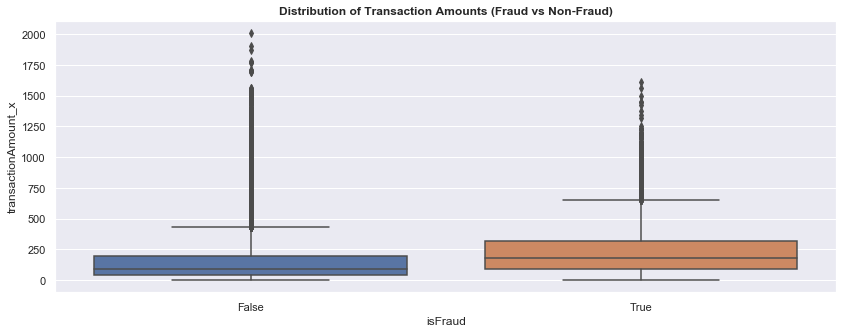

In [109]:
plt.figure(figsize=(14,5))
plt.title('Distribution of Transaction Amounts (Fraud vs Non-Fraud)',weight='bold')
sns.set()
sns.boxplot(x='isFraud', y='transactionAmount_x', data=processed)

In [98]:
processed.shape

(730174, 30)

In [89]:
final_data=processed[['customerId_x','merchantName_x','transactionAmount_x','transactionType_x','transactionKey','Timestamp','creditLimit','availableMoney','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','currentBalance','cardPresent','expirationDateKeyInMatch','isFraud']]

In [91]:
final_data.columns=['customerId','merchantName','transactionAmount','transactionType','transactionKey','Timestamp','creditLimit','availableMoney','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','currentBalance','cardPresent','expirationDateKeyInMatch','isFraud']

In [93]:
final_data.to_csv('clean_data.csv',index=False)

In [94]:
#q=pd.read_csv('./clean_data.csv')
#q.shape

In [102]:
final_data.head(3)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,creditLimit,availableMoney,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36,50000,49953.81,US,9.0,1.0,food,46.19,True,False,False
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06,50000,49929.31,US,2.0,1.0,food,70.69,True,False,False
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01,50000,49996.04,US,2.0,1.0,food,3.96,True,False,False


**I found 56189 observations as duplicates (combination of both reversal and multi-swipes) that corresponds to 7.07% of original data.**

In [96]:
786363 - 730174

56189

In [97]:
round(56189/786363,2)

0.07

-------